# 第五章 变分量子算法 （Variational quantum algorithms）

In [1]:
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorcircuit as tc

K = tc.set_backend("tensorflow")

## 1. 变分量子算法：框架和组件

&emsp;&emsp;变分量子算法是一种适合“近期有噪声中等规模量子线路”（Noisy Intermediate-Scale Quantum, NISQ）的基于变分优化的量子经典混合算法。其是在近期最有希望达成量子优势的算法方向。通过充分利用大量含噪声的量子比特的表达能力，来实现无完整纠错情况下相关问题的近似和解决。深入了解这一领域可以参考综述性文章【1,2】。
    
&emsp;&emsp;变分量子算法典型的工作流类似于深度学习，主要区别是深度学习中的神经网络组件被参数化的量子线路替代。所谓参数化量子线路 $U(\theta)$ 指的是对应线路矩阵由可变参数组 $\theta$ 决定的线路。实现上，一般以旋转角度可变的参数化量子门来表达参数化量子线路，旋转门上的参数构成了参数集。我们通过经典的优化器来调整线路上的参数，使得参数化量子线路输出的波函数为 $\vert \psi\rangle = U(\theta)\vert 0\rangle$，其对应的具体问题损失函数 $L(\vert \psi\rangle)$ 最小。整体计算过程如下图所示：

<div align = center>
<img src="./img/vqa.jpg" width="90%" />
<figcaption align = "center"> 变分量子算法结构
</figcaption>
</div>

### 1.1 变分算法

在介绍变分量子算法的组件前，我们先回顾变分算法的框架，本节我们以求目标函数 $f(x, y) = x^2 + y^2 + 2x + xy$ 的最小值为例，来展示变分算法的框架。

首先我们定义函数，输入为参数，输出为目标函数的标量值。

In [19]:
def f(params):
    x, y = params[0], params[1]
    return x**2 + y**2 + 2 * x + x * y


f(K.convert_to_tensor([0.2, 0.5]))

<tf.Tensor: shape=(), dtype=float32, numpy=0.79>

对于输入参数的调整，如果调整是沿着参数的梯度方向，则对应的函数值将会下降，这也就是梯度下降优化。那么我们需要首先知道 $\partial f/\partial x$ 和 $\partial f/\partial y$。对于这些梯度信息，复杂函数将无法解析求得，我们才有机器学习库的自动微分框架来计算，这一框架对用户是透明的，我们只需要调用如下 API。

In [21]:
pf = K.grad(f)

pf(K.convert_to_tensor([0.2, 0.5]))

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2.9, 1.2], dtype=float32)>

上述函数的意思即为 $\partial f/\partial x\vert _{x=0.2, y=0.5} = 2.9$, $\partial f/\partial y\vert _{x=0.2, y=0.5} = 1.2$。该结果在现在简单的解析表达式损失函数下，可以解析验证。

### 1.2 参数化量子线路

&emsp;&emsp;参数化量子线路在变分量子算法中的角色类似于神经网络在深度学习中的角色，量子线路中的参数对应了神经网络中的可调权重。更具体地说，通过在参数化量子线路上测量各种观察量的期望值，我们可以通过这些期望值来构造适合具体问题的相应损失函数。通过经典的优化器的算法，我们可以根据不同线路参数对应的损失函数的值来进一步调节线路参数的取值，从而使得问题对应的损失函数最小，实现对该类问题的近似解。

&emsp;&emsp;变分线路 $U(\theta)$ 可以具有多样的结构，比如同类型原生量子门密排的硬件节约假设（hardware efficient ansatz），或是基于量子化学变分波函数的 UCC 假设等。此外还有受绝热演化启发和张量网络启发的量子线路结构实现。两种阶梯排布和砖块排布的硬件节约假设如下。

* 双比特门阶梯排布

In [2]:
n, nlayers = 4, 2
# number of qubits, number of layers


def ladder_layout_circuit(params, pbc=False):
    """
    `params` is for circuit trainable parameters
    """
    c = tc.Circuit(n)
    offset = 0 if pbc else 1
    for j in range(nlayers):
        for i in range(n - offset):
            c.cnot(i, (i + 1) % n)
        for i in range(n):
            c.rx(i, theta=params[j, i])
    return c

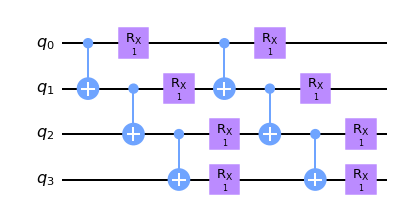

In [3]:
## open boundary ladder

ladder_layout_circuit(K.ones(shape=[nlayers, n])).draw(output="mpl")

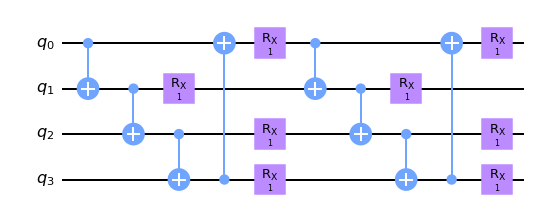

In [4]:
## periodic boundary ladder

ladder_layout_circuit(K.ones(shape=[nlayers, n]), pbc=True).draw(output="mpl")

* 双比特门砖块排布

In [5]:
def brickwall_layout_circuit(params, pbc=False):
    """
    `params` is for circuit trainable parameters
    """
    c = tc.Circuit(n)
    offset = 0 if pbc else 1
    for j in range(nlayers):
        for i in range(0, n - offset, 2):
            c.cnot(i, (i + 1) % n)
        for i in range(n):
            c.rx(i, theta=params[j, i, 0])
        for i in range(1, n - offset, 2):
            c.cnot(i, (i + 1) % n)
        for i in range(n):
            c.rx(i, theta=params[j, i, 1])
    return c

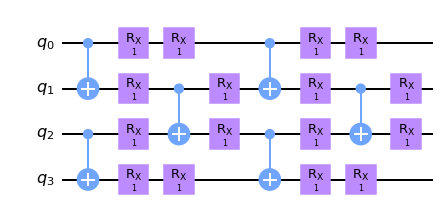

In [6]:
## open boundary brickwall

brickwall_layout_circuit(K.ones(shape=[nlayers, n, 2])).draw(output="mpl")

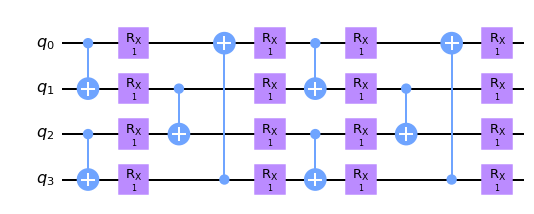

In [7]:
## periodic boundary brickwall

brickwall_layout_circuit(K.ones(shape=[nlayers, n, 2]), pbc=True).draw(output="mpl")

&emsp;&emsp;对于双比特门，我们也可以直接使用参数化的双比特门，比如 $e^{i\theta ZZ}$，该形式的门可以程序表示为

zz matrix:
 [[ 1.  0.  0.  0.]
 [ 0. -1.  0. -0.]
 [ 0.  0. -1. -0.]
 [ 0. -0. -0.  1.]]


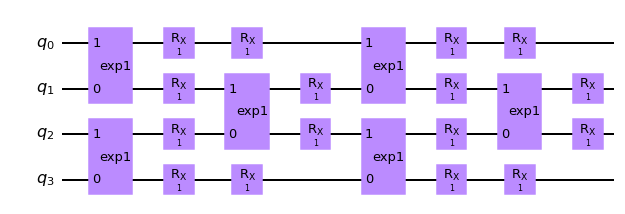

In [8]:
zz = tc.gates._zz_matrix
print("zz matrix:\n", zz)


def brickwall_vtwo_layout_circuit(params, pbc=False):
    """
    `params` is for circuit trainable parameters
    """
    c = tc.Circuit(n)
    offset = 0 if pbc else 1
    for j in range(nlayers):
        for i in range(0, n - offset, 2):
            c.exp1(i, (i + 1) % n, theta=params[j, i, 2], unitary=zz)
        for i in range(n):
            c.rx(i, theta=params[j, i, 0])
        for i in range(1, n - offset, 2):
            c.exp1(i, (i + 1) % n, theta=params[j, i, 2], unitary=zz)
        for i in range(n):
            c.rx(i, theta=params[j, i, 1])
    return c


brickwall_vtwo_layout_circuit(K.ones(shape=[nlayers, n, 3])).draw(output="mpl")

### 1.3 损失函数

&emsp;&emsp;损失函数为通过线路输出上的各种观察量的值构造的适合特定问题解决的需要最小化的标量函数。

&emsp;&emsp;假设参数化线路输出的波函数为 $\vert\psi\rangle = U(\theta)\vert 0\rangle$, 常见的损失函数包括：

1. 特定系统的基态能量，若系统的厄米哈密顿量矩阵为 $H$, 损失函数为 $L=\langle \psi \vert H\vert \psi\rangle$. 
2. 特定的生成目标态 $\vert \phi \rangle$，可以以内积为损失函数 $L=\langle \psi\vert \phi\rangle$. 
3. 有监督的量子机器学习任务，若数据集为 $\vert \psi_i\rangle, y_i$，变分线路为 $U$，则损失函数可取为 
$$L=\sum_{j} \left(\left\langle\psi_{j}|U^{\dagger}H U| \psi_{j}\right\rangle-y_{j}\right)^{2}。
$$

对于能量估计类型的损失函数 1，测量上通常可以将哈密顿量矩阵 H 分解成若干个 Pauli 算符直积态的和，比如一维 n 个自由度横场伊辛模型的哈密顿量为：
$$H = \sum_{i=0}^{n-1} J_i Z_i Z_{i+1} + h_i X_i.$$
比如 $Z_0Z_1$ 即是 $Z\otimes Z \otimes I \otimes I \otimes \cdots$ 的简写，代表了一个 Pauli 字符串。

数值上我们既可以一次构造出各个 Pauli 字符串测量，也可以直接根据 kronecker 积的定义计算出具体的哈密顿量矩阵的形式，从而加速计算，两种方式的能量函数计算展示如下。

1. 能量期望（Pauli 字符串期望相加形式）

In [9]:
c = brickwall_vtwo_layout_circuit(K.ones(shape=[nlayers, n, 3]))


def loss(c, j, h):
    e = 0
    for i in range(c._nqubits - 1):
        e += j[i] * c.expectation_ps(z=[i, i + 1])
    for i in range(c._nqubits):
        e += h[i] * c.expectation_ps(x=[i])
    return K.real(e)


loss(c, K.ones([n - 1]), K.ones([n]))

<tf.Tensor: shape=(), dtype=float32, numpy=2.0465765>

2. 能量期望（矩阵形式）

In [10]:
def loss_matrix(c, j, h):
    # build the matrix by feed the pauli string structure
    n = c._nqubits
    structures = []
    for i in range(n - 1):
        s = [0 for _ in range(n)]
        s[i] = 3
        s[i + 1] = 3
        # ZiZi+1: 3 for Z, 0 for I
        structures.append(s)
    for i in range(n):
        s = [0 for _ in range(n)]
        s[i] = 1
        # Xi; 1 for X
        structures.append(s)
    structures = K.convert_to_tensor(structures)
    weights = K.concat([j, h])

    # generate the matrix based on structures and weights for Pauli strings

    m = tc.quantum.PauliStringSum2COO(structures, weights)
    print("sparse matrix for H:\n", type(m))

    return tc.templates.measurements.operator_expectation(c, m)


loss_matrix(c, K.ones([n - 1]), K.ones([n]))

sparse matrix for H:
 <class 'tensorflow.python.framework.sparse_tensor.SparseTensor'>


<tf.Tensor: shape=(), dtype=float32, numpy=2.0465765>

3. 内积

In [11]:
# 目标函数

phi = K.implicit_randn(shape=[2**n])
phi /= K.norm(phi)
phi = K.cast(phi, dtype="complex64")


def loss_overlap(c):
    s = c.state()
    inner = K.tensordot(K.conj(s), phi, 1)
    return 1 - K.abs(inner)


loss_overlap(c)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9713958>

### 1.4 优化器与梯度下降

和经典变分优化类似，为了优化损失函数，需要对量子线路中的参数进行调整，这一调整通常通过经典的优化器进行，包括了常见的基于梯度下降的优化器，因此我们需要得到损失函数相对线路参数的梯度信息。

为了得到损失函数关于量子线路参数的梯度数值，真实硬件上需要使用参数平移的方法（可参考如 https://pennylane.ai/qml/glossary/parameter_shift.html 计算严格的导数。

数值上，我们可以利用深度学习库的反向传播来更高效地计算线路参数梯度。示例如下。

In [12]:
# the whole forward pipeline from circuit weights to loss scalar


def forward(params):
    c = brickwall_vtwo_layout_circuit(params)
    return loss_overlap(c)

In [13]:
# get the loss function value

forward(K.ones(shape=[nlayers, n, 3]))

<tf.Tensor: shape=(), dtype=float32, numpy=0.9713958>

In [14]:
# get the circuit gradient by wrapping the forward pipeline

vgf = K.value_and_grad(forward)

vgf(K.ones(shape=[nlayers, n, 3], dtype="float32"))

# returns value and circuit gradient tuple via automatic differentiation

(<tf.Tensor: shape=(), dtype=float32, numpy=0.9713958>,
 <tf.Tensor: shape=(2, 4, 3), dtype=float32, numpy=
 array([[[ 5.4111667e-02,  5.4111667e-02,  4.8428774e-08],
         [ 4.7795512e-02, -3.1667841e-03,  5.7513312e-02],
         [-1.9392693e-01,  2.2526062e-01,  5.0291419e-08],
         [-2.2852177e-02, -2.2852177e-02,  0.0000000e+00]],
 
        [[ 5.6857504e-02,  5.6857504e-02, -1.3088252e-01],
         [ 4.2077001e-02, -2.9914312e-02, -2.3675665e-01],
         [-4.2712502e-02, -4.7387734e-02,  8.0374084e-02],
         [-4.4065560e-03, -4.4065570e-03,  0.0000000e+00]]], dtype=float32)>)

梯度下降的优化循环和深度学习类似，我们需要一个优化器并迭代更新参数：

In [15]:
params = K.implicit_randn(shape=[nlayers, n, 3])
history = []
opt = K.optimizer(tf.keras.optimizers.Adam(1e-2))

# the main optimization loop
for _ in range(200):
    v, g = vgf(params)
    params = opt.update(g, params)  # gradient descent params with gradient g
    history.append(v)

Text(0.5, 0, 'training step')

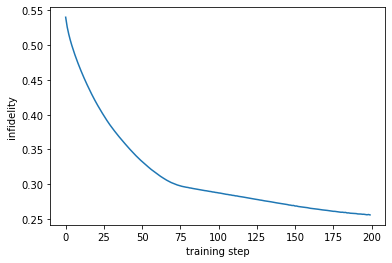

In [16]:
## visualization the optimization curve

plt.plot([i for i in range(200)], history)
plt.ylabel("infidelity")
plt.xlabel("training step")

## 2. 变分量子算法：应用

**广泛应用**：组合优化问题、多体系统（量子格点模型或分子）的基态和激发态的求解问题、变分的线性方程和微分方程的近似解、机器学习相关的如判别模型或生成模型问题、基于变分的质因数分解问题等等。


### 2.1 变分量子算法在组合优化问题上的应用

【WIP】insert tutorial link here

### 2.2 变分量子算法在量子机器学习上的应用

量子机器学习利用变分量子线路作为判别器进行训练，有望实现较传统经典神经网络更加强大的泛化性能，从而体现量子优势。

* https://tensorcircuit.readthedocs.io/zh/latest/tutorials/mnist_qml_cn.html
* https://tensorcircuit.readthedocs.io/zh/latest/tutorials/torch_qml_cn.html
* https://tensorcircuit.readthedocs.io/zh/latest/tutorials/qml_scenarios_cn.html

### 2.3 变分量子算法在物理化学系统量子模拟上的应用

物理模型和化学分子的模拟评估，是量子计算机发挥作用的最重要领域之一，有望引领新材料和新能源的发现和创新。

* https://tensorcircuit.readthedocs.io/zh/latest/tutorials/tfim_vqe_cn.html
* https://tensorcircuit.readthedocs.io/zh/latest/tutorials/vqe_h2o_cn.html
* https://tensorcircuit.readthedocs.io/zh/latest/tutorials/tfim_vqe_diffreph_cn.html

## 参考文献

【1】Bharti, K., Cervera-Lierta, A., Kyaw, T. H., Haug, T., Alperin-Lea, S., Anand, A., Degroote, M., Heimonen, H., Kottmann, J. S., Menke, T., Mok, W.-K., Sim, S., Kwek, L.-C., & Aspuru-Guzik, A. (2022). Noisy intermediate-scale quantum algorithms. Reviews of Modern Physics, 94(1), 015004. https://doi.org/10.1103/RevModPhys.94.015004

【2】Cerezo, M., Arrasmith, A., Babbush, R., Benjamin, S. C., Endo, S., Fujii, K., McClean, J. R., Mitarai, K., Yuan, X., Cincio, L., & Coles, P. J. (2021). Variational quantum algorithms. Nature Reviews Physics, 3(9), 625–644. https://doi.org/10.1038/s42254-021-00348-9